# Convolutional Neural Networks: Step by Step

Welcome to Course 4's first assignment! In this assignment, you will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and (optionally) backward propagation. 

By the end of this notebook, you'll be able to: 

* Explain the convolution operation
* Apply two different types of pooling operation
* Identify the components used in a convolutional neural network (padding, stride, filter, ...) and their purpose
* Build a convolutional neural network 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

You should be familiar with `numpy` and/or have completed the previous courses of the specialization. Let's get started!

## Table of Contents

- [1 - Packages](#1)
- [2 - Outline of the Assignment](#2)
- [3 - Convolutional Neural Networks](#3)
    - [3.1 - Zero-Padding](#3-1)
        - [Exercise 1 - zero_pad](#ex-1)
    - [3.2 - Single Step of Convolution](#3-2)
        - [Exercise 2 - conv_single_step](#ex-2)
    - [3.3 - Convolutional Neural Networks - Forward Pass](#3-3)
        - [Exercise 3 - conv_forward](#ex-3)
- [4 - Pooling Layer](#4)
    - [4.1 - Forward Pooling](#4-1)
        - [Exercise 4 - pool_forward](#ex-4)
- [5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)](#5)
    - [5.1 - Convolutional Layer Backward Pass](#5-1)
        - [5.1.1 - Computing dA](#5-1-1)
        - [5.1.2 - Computing dW](#5-1-2)
        - [5.1.3 - Computing db](#5-1-3)
            - [Exercise 5 - conv_backward](#ex-5)
    - [5.2 Pooling Layer - Backward Pass](#5-2)
        - [5.2.1 Max Pooling - Backward Pass](#5-2-1)
            - [Exercise 6 - create_mask_from_window](#ex-6)
        - [5.2.2 - Average Pooling - Backward Pass](#5-2-2)
            - [Exercise 7 - distribute_value](#ex-7)
        - [5.2.3 Putting it Together: Pooling Backward](#5-2-3)
            - [Exercise 8 - pool_backward](#ex-8)

<a name='1'></a>
## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. This helps to grade your work.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from public_tests import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='2'></a>
## 2 - Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions to walk you through the steps:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
This notebook will ask you to implement these functions from scratch in `numpy`. In the next notebook, you will use the TensorFlow equivalents of these functions to build the following model:

<img src="images/model.png" style="width:800px;height:300px;">

**Note**: For every forward function, there is a corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

<a name='3-1'></a>
### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Zero-Padding</b><br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels at the edges of an image.

<a name='ex-1'></a>
### Exercise 1 - zero_pad
Implement the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [2]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    #(≈ 1 line)
    # X_pad = None
    # YOUR CODE STARTS HERE
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode = "constant", constant_values = (0, 0))
    
    # YOUR CODE ENDS HERE
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 All tests passed.


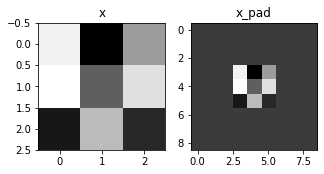

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

assert type(x_pad) == np.ndarray, "Output must be a np array"
assert x_pad.shape == (4, 9, 9, 2), f"Wrong shape: {x_pad.shape} != (4, 9, 9, 2)"
print(x_pad[0, 0:2,:, 0])
assert np.allclose(x_pad[0, 0:2,:, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Rows are not padded with zeros"
assert np.allclose(x_pad[0, :, 7:9, 1].transpose(), [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Columns are not padded with zeros"
assert np.allclose(x_pad[:, 3:6, 3:6, :], x, 1e-15), "Internal values are different"

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
zero_pad_test(zero_pad)

<a name='3-2'></a>
### 3.2 - Single Step of Convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;"/>
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : <b>Convolution operation</b><br/> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>


In a computer vision application, each value in the matrix on the left corresponds to a single pixel value. You convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, you will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

<a name='ex-2'></a>
### Exercise 2 - conv_single_step
Implement `conv_single_step()`. 
    
[Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).

**Note**: The variable b will be passed in as a numpy array.  If you add a scalar (a float or integer) to a numpy array, the result is a numpy array.  In the special case of a numpy array containing a single value, you can cast it as a float to convert it to a scalar.

In [4]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    #(≈ 3 lines of code)
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    # s = None
    # Sum over all entries of the volume s.
    # Z = None
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    # Z = None
    # YOUR CODE STARTS HERE
    S = np.sum(a_slice_prev * W)
    Z = S + float(b)
    
    # YOUR CODE ENDS HERE

    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)
conv_single_step_test(conv_single_step)

assert (type(Z) == np.float64 or type(Z) == np.float32), "You must cast the output to float"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221
 All tests passed.


<a name='3-3'></a>
### 3.3 - Convolutional Neural Networks - Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<a name='ex-3'></a>
### Exercise 3 -  conv_forward
Implement the function below to convolve the filters `W` on an input activation `A_prev`.  
This function takes the following inputs:
* `A_prev`, the activations output by the previous layer (for a batch of m inputs); 
* Weights are denoted by `W`.  The filter window size is `f` by `f`.
* The bias vector is `b`, where each filter has its own (single) bias. 

You also have access to the hyperparameters dictionary, which contains the stride and the padding. 

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.

2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corners can be defined using h, w, f and s in the code below.

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)</b> <br> This figure shows only a single channel.  </center></caption>


**Reminder**:
    
The formulas relating the output shape of the convolution to the input shape are:
    
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    



For this exercise, don't worry about vectorization! Just implement everything with for-loops.

#### Additional Hints (if you're stuck):


* Use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  - Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  - Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the `vert_start`, `vert_end`, `horiz_start`, `horiz_end`, remember that these are indices of the previous layer.  
  - Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  - The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  - Think about which one should be used within the for loops.

In [9]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    # (m, n_H_prev, n_W_prev, n_C_prev) = None


    # Retrieve dimensions from W's shape (≈1 line)
    # (f, f, n_C_prev, n_C) = None

    
    # Retrieve information from "hparameters" (≈2 lines)
    # stride = None
    # pad = None

    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    # n_H = None
    # n_W = None

    
    # Initialize the output volume Z with zeros. (≈1 line)
    # Z = None

    
    # Create A_prev_pad by padding A_prev
    # A_prev_pad = None

    
    # for i in range(None):               # loop over the batch of training examples
        # a_prev_pad = None               # Select ith training example's padded activation
        # for h in range(None):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            # vert_start = None
            # vert_end = None
            
            # for w in range(None):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                # horiz_start = None
                # horiz_end = None
                
                # for c in range(None):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    # a_slice_prev = None
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    # weights = None
                    # biases = None
                    # Z[i, h, w, c] = None
    # YOUR CODE STARTS HERE

    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape

    f, f, n_C_prev, n_C = W.shape

    stride = hparameters["stride"]
    pad = hparameters["pad"]

    n_H = int((n_H_prev + 2 * pad - f) / stride + 1)
    n_W = int((n_W_prev + 2 * pad - f) / stride + 1)

    Z = np.zeros((m, n_H, n_W, n_C))

    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        
        for h in range(0, n_H):
            vert_start = h *  stride
            vert_end = vert_start + f
            
            for w in range(0, n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                
                for c in range(n_C):
                    weights = np.sum(W[:, :, :, c:c + 1], 3)
                    biases = np.sum(b[:, :, :, c:c + 1], 3)

                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # YOUR CODE ENDS HERE
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[0,2,1] =\n", Z[0, 2, 1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

conv_forward_test(conv_forward)

Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]
(2, 13, 15, 8)
 All tests passed.


Finally, a CONV layer should also contain an activation, in which case you would add the following line of code:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```

You don't need to do it here, however. 


<a name='4'></a>
## 4 - Pooling Layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 

<a name='4-1'></a>
### 4.1 - Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function. 

<a name='ex-4'></a>
### Exercise 4 - pool_forward

Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$




In [11]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    # for i in range(None):                         # loop over the training examples
        # for h in range(None):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            # vert_start = None
            # vert_end = None
            
            # for w in range(None):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                # horiz_start = None
                # horiz_end = None
                
                # for c in range (None):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    # a_prev_slice = None
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    # if mode == "max":
                        # A[i, h, w, c] = None
                    # elif mode == "average":
                        # A[i, h, w, c] = None
    
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    #assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache